In [59]:
import numpy as np
import pandas as pd
import cv2
import skfuzzy as fuzz
import skfuzzy.control as ctrl
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

In [35]:
#Load dataset path
dataset_path = r"C:\Users\Stiena\Documents\VIT\Alzheimer's disease\Alzheimer's disease\Capstone-Alzheimer's-present\Data"


In [36]:
#Function to analyze dataset bias
def analyze_bias(class_counts):
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xlabel("Class Labels")
    plt.ylabel("Number of Samples")
    plt.title("Dataset Class Distribution")
    plt.xticks(rotation=30)
    plt.show()

In [37]:
#Ensure class names match the dataset folders exactly
dataset_classes = {
    "Mild Dementia": 500,
    "Moderate Dementia": 200,
    "Very mild Dementia": 100, 
    "Non Demented": 1200  
}

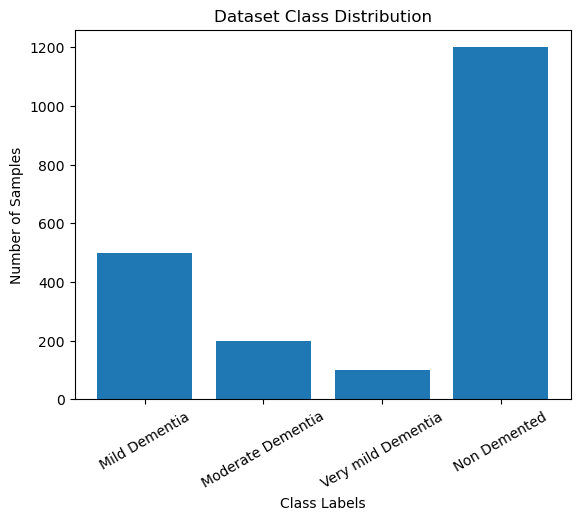

In [38]:
#Show original distribution
analyze_bias(dataset_classes)

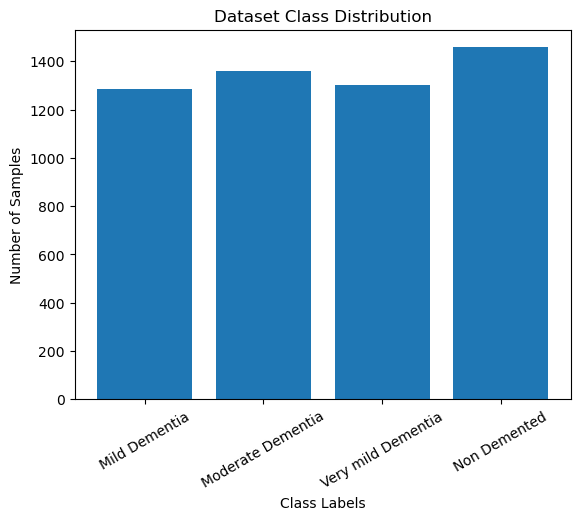

In [48]:
# Define fuzzy variables
imbalance = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'imbalance')
resample_factor = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'resample_factor')

# Define fuzzy membership functions
imbalance['low'] = fuzz.trimf(imbalance.universe, [0, 0, 0.5])
imbalance['medium'] = fuzz.trimf(imbalance.universe, [0.3, 0.5, 0.7])
imbalance['high'] = fuzz.trimf(imbalance.universe, [0.5, 1, 1])

resample_factor['low'] = fuzz.trimf(resample_factor.universe, [0, 0, 0.3])
resample_factor['medium'] = fuzz.trimf(resample_factor.universe, [0.2, 0.5, 0.7])
resample_factor['high'] = fuzz.trimf(resample_factor.universe, [0.6, 1, 1])

# Define fuzzy rules
rule1 = ctrl.Rule(imbalance['low'], resample_factor['low'])
rule2 = ctrl.Rule(imbalance['medium'], resample_factor['medium'])
rule3 = ctrl.Rule(imbalance['high'], resample_factor['high'])

control_system = ctrl.ControlSystem([rule1, rule2, rule3])
resampler = ctrl.ControlSystemSimulation(control_system)

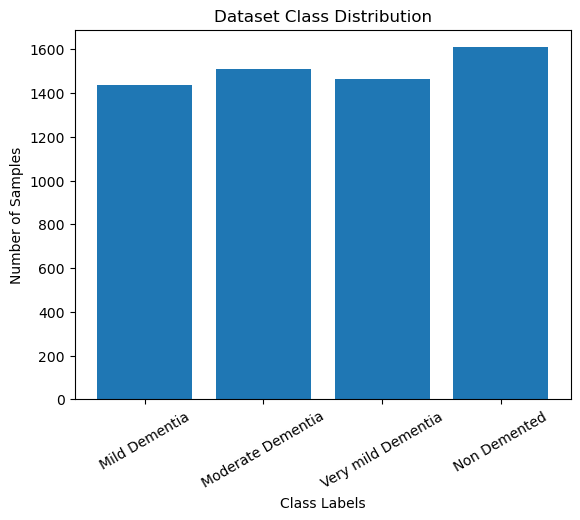

In [52]:
# Apply fuzzy logic for dataset balancing
for class_label, count in dataset_classes.items():
    imbalance_score = 1 - (count / max(dataset_classes.values()))
    resampler.input['imbalance'] = imbalance_score
    resampler.compute()
    factor = resampler.output['resample_factor']
    target_size = int(count + factor * max(dataset_classes.values()))
    dataset_classes[class_label] = target_size

# Show updated distribution
analyze_bias(dataset_classes)

In [53]:
# Image Augmentation
generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

In [54]:
# Load and preprocess dataset
data, labels = [], []
class_mapping = {label: idx for idx, label in enumerate(dataset_classes.keys())}  # Mapping class names to integers

for class_label in dataset_classes.keys():
    class_path = os.path.join(dataset_path, class_label)
    if not os.path.exists(class_path):
        print(f"Warning: Folder '{class_path}' not found. Skipping...")
        continue
    
    for img_name in os.listdir(class_path)[:dataset_classes[class_label]]:
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, (128, 128))
        data.append(img)
        labels.append(class_mapping[class_label])  # Convert label to integer

In [56]:
from tensorflow.keras.utils import to_categorical

# Convert to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Debugging: Check unique labels before one-hot encoding
print("Unique labels before one-hot encoding:", np.unique(labels))  # Should print [0 1 2 3]

# One-hot encode labels
labels = to_categorical(labels, num_classes=len(dataset_classes))  # Fix applied here ✅

# Check the new shape
print("Labels shape after one-hot encoding:", labels.shape)  # Should be (num_samples, 4)


Unique labels before one-hot encoding: [0 1 2 3]
Labels shape after one-hot encoding: (4997, 4)


In [57]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

In [60]:
# Load MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(len(dataset_classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [61]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=32)

Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.4019 - loss: 1.4228 - val_accuracy: 0.6270 - val_loss: 0.8435
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.6278 - loss: 0.8813 - val_accuracy: 0.7140 - val_loss: 0.7004
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.7075 - loss: 0.7324 - val_accuracy: 0.7810 - val_loss: 0.6129
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.7600 - loss: 0.6204 - val_accuracy: 0.7590 - val_loss: 0.5744
Epoch 5/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.7914 - loss: 0.5648 - val_accuracy: 0.8270 - val_loss: 0.5010
Epoch 6/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.8333 - loss: 0.5063 - val_accuracy: 0.8270 - val_loss: 0.4595
Epoch 7/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.8300 - loss: 0.4899 - val_accuracy: 0.8460 - val_loss: 0.4197
Epoch 8/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.8465 - loss: 0.4422 - val_acc

In [62]:
# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       288
           1       0.97      0.92      0.94        98
           2       0.91      0.90      0.91       292
           3       0.92      0.93      0.93       322

    accuracy                           0.92      1000
   macro avg       0.93      0.92      0.93      1000
weighted avg       0.92      0.92      0.92      1000



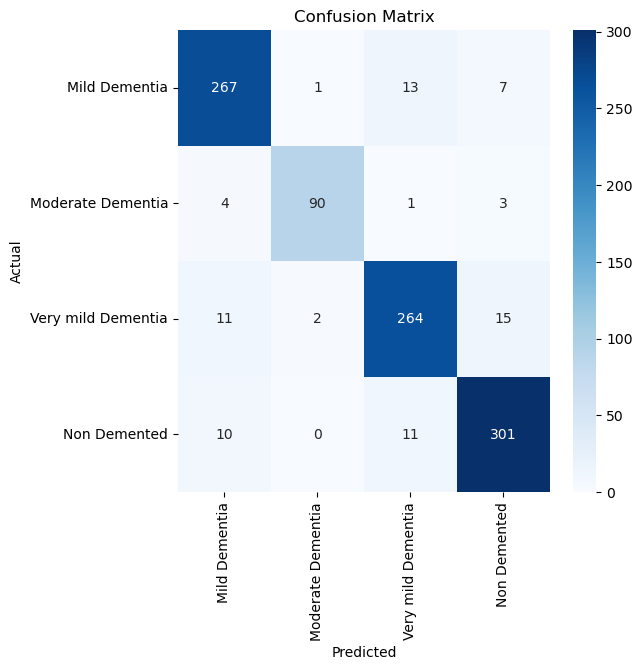

In [63]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset_classes.keys(), yticklabels=dataset_classes.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

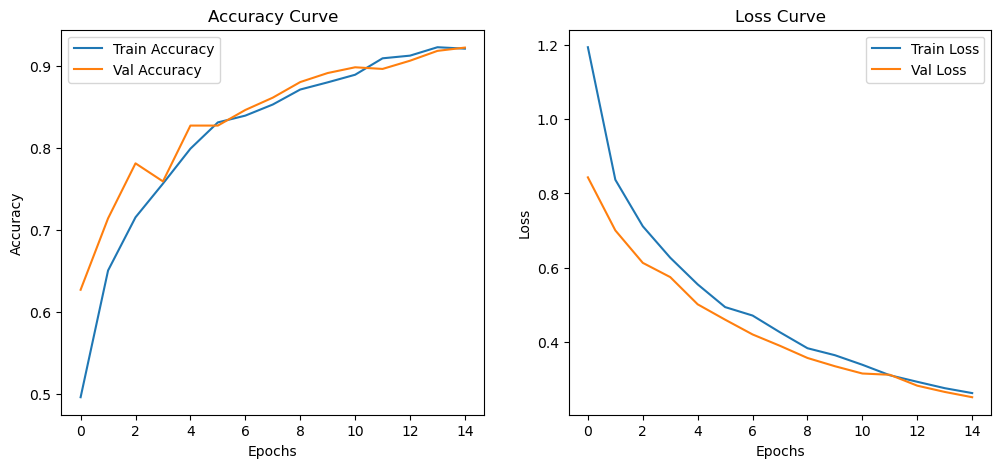

✅ Model training and evaluation completed successfully!


In [64]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()

print("✅ Model training and evaluation completed successfully!")